# EVAC Assessment 2 - Society-based Cooperation

In [1]:
import random
from enums import Society
from deap import creator, base, tools
from collections import Counter
import itertools
import logging
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(level=logging.INFO) # Initializes the logging level used to output to console

In [2]:
HIST_SIZE = 2
IND_SIZE = 4**HIST_SIZE

OUTCOMES = {
    # Saints cooperate with everyone
    (Society.SAINTS, Society.SAINTS):           (4,4), # Both cooperate
    (Society.SAINTS, Society.BUDDIES):          (0,6), # Buddies are selfish
    (Society.SAINTS, Society.FIGHT_CLUB):       (4,4), # Both cooperate
    (Society.SAINTS, Society.VANDALS):          (0,6), # Vandals are selfish

    # Buddies only cooperate with each other
    (Society.BUDDIES, Society.SAINTS):          (6,0), # Buddies are selfish
    (Society.BUDDIES, Society.BUDDIES):         (4,4), # Both cooperate
    (Society.BUDDIES, Society.FIGHT_CLUB):      (6,0), # Buddies are selfish
    (Society.BUDDIES, Society.VANDALS):         (1,1), # Both selfish
    
    # Fight club cooperate with everyone but themselves
    (Society.FIGHT_CLUB, Society.SAINTS):       (4,4), # Both cooperate
    (Society.FIGHT_CLUB, Society.BUDDIES):      (0,6), # Buddies are selfish
    (Society.FIGHT_CLUB, Society.FIGHT_CLUB):   (1,1), # Both selfish
    (Society.FIGHT_CLUB, Society.VANDALS):      (0,6), # Vandals are selfish
    
    # Vandals cooperate with no one
    (Society.VANDALS, Society.SAINTS):          (6,0), # Vandals are selfish
    (Society.VANDALS, Society.BUDDIES):         (1,1), # Both selfish
    (Society.VANDALS, Society.FIGHT_CLUB):      (6,0), # Vandals are selfish
    (Society.VANDALS, Society.VANDALS):         (1,1), # Both selfish
}

HISTORY_LOOKUP = {y: x for x, y in dict(enumerate(itertools.product([society.value for society in Society], repeat=HIST_SIZE))).items()}

In [3]:
def reset_population(population):
    for indiv in population:
        indiv.total_score = 0
        indiv.rounds_played = 0
        indiv.society = random.choice(list(Society))
        indiv.history = [random.choice([society.value for society in Society]) for i in range(HIST_SIZE)]


def play_round(indiv1, indiv2):
    indiv1.rounds_played += 1
    indiv2.rounds_played += 1
    
    payoffs = OUTCOMES[(indiv1.society, indiv2.society)]
    indiv1.total_score += payoffs[0]
    indiv2.total_score += payoffs[1]

    new_match = [indiv1.society.value, indiv2.society.value]
    indiv1.history = indiv1.history[2:HIST_SIZE] + new_match
    indiv2.history = indiv2.history[2:HIST_SIZE] + new_match[::-1]

    chr1_index = HISTORY_LOOKUP[tuple(indiv1.history)]
    indiv1.society = Society(indiv1[chr1_index])

    chr2_index = HISTORY_LOOKUP[tuple(indiv2.history)]
    indiv2.society = Society(indiv2[chr2_index])

def evaluate_agents(population, num_rounds):
    for i in range(num_rounds):
        indiv1 = random.choice(population)
        indiv2 = random.choice(population)
        while indiv2 == indiv1:
            indiv2 = random.choice(population)
        play_round(indiv1, indiv2)
    
    for ind in population:
        if ind.rounds_played == 0:
            ind.fitness.values = 0,
        else:
            ind.fitness.values = ind.total_score / ind.rounds_played,

def print_indiv(indiv):
    print("~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"{indiv.total_score=}")
    print(f"{indiv.rounds_played=}")
    print(f"{indiv.society=}")
    print(f"{indiv.history=}")
    print("~~~~~~~~~~~~~~~~~~~~~~~")

def run_GA(gen_num=200, pop_num=20, round_num=400, mut_prob=0.021, cx_prob=0.15, tourn_size=5, headless=True):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax, total_score=0, rounds_played=0, society=Society.SAINTS, history = [0 for i in range(HIST_SIZE)])

    toolbox = base.Toolbox()
    toolbox.register("attr_int", random.choice, [society.value for society in Society])
    toolbox.register("attr_binary", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n = IND_SIZE)

    toolbox.register("evaluate", evaluate_agents)

    # Registers function to select, mate and mutate individuals
    toolbox.register("select", tools.selTournament, tournsize=tourn_size)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=mut_prob)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("reset_population", reset_population)

    # Registers the statistics & logbook that will be logged during the GA
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats2 = tools.Statistics(key=lambda ind: ind.society.value)

    stats.register("mean", np.mean)
    stats.register("std", np.std)
    stats.register("median", np.median)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook2 = tools.Logbook()

    population = toolbox.population(pop_num)
    toolbox.reset_population(population)

    toolbox.evaluate(population, round_num)

    counts = {
        Society.SAINTS: [],
        Society.BUDDIES: [],
        Society.FIGHT_CLUB: [],
        Society.VANDALS: []
    }

    # Genetic Algorithm
    for g in range(gen_num):
        logging.info(f"-- Generation {g+1}/{gen_num} --")

        # Selects number of individuals equal to population length
        offspring = toolbox.select(population, len(population))
        
        # Includes duplicates so clones all individuals
        offspring = list(map(toolbox.clone, offspring))

        # Performs crossover on 2 individuals based on previously defined probability
        for indiv1, indiv2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(indiv1, indiv2)

        # Mutates offspring based on previously defined probability #TODO: Modify probability/algorithm type?
        for mutant in offspring:
            toolbox.mutate(mutant)
        
        toolbox.reset_population(offspring)

        # Recalculates fitness values for mutated offspring
        toolbox.evaluate(offspring, round_num)

        # Replaces old population with new mutated offspring
        population[:] = offspring

        # Compiles & records the statistics for the new generation
        
        record = stats.compile(population)
        logging.debug(record)
        logbook.record(gen=g, **record)

        assignments = [indiv.society for indiv in population]
        for society in Society:
            counts[society].append(assignments.count(society))

    return logbook, counts


In [4]:
lb, counts = run_GA(gen_num=200, pop_num=2000, round_num=10000, mut_prob=0.05, cx_prob=0.15, tourn_size=200, headless=True)

INFO:root:-- Generation 1/200 --
INFO:root:-- Generation 2/200 --
INFO:root:-- Generation 3/200 --
INFO:root:-- Generation 4/200 --
INFO:root:-- Generation 5/200 --
INFO:root:-- Generation 6/200 --
INFO:root:-- Generation 7/200 --
INFO:root:-- Generation 8/200 --
INFO:root:-- Generation 9/200 --
INFO:root:-- Generation 10/200 --
INFO:root:-- Generation 11/200 --
INFO:root:-- Generation 12/200 --
INFO:root:-- Generation 13/200 --
INFO:root:-- Generation 14/200 --
INFO:root:-- Generation 15/200 --
INFO:root:-- Generation 16/200 --
INFO:root:-- Generation 17/200 --
INFO:root:-- Generation 18/200 --
INFO:root:-- Generation 19/200 --
INFO:root:-- Generation 20/200 --
INFO:root:-- Generation 21/200 --
INFO:root:-- Generation 22/200 --
INFO:root:-- Generation 23/200 --
INFO:root:-- Generation 24/200 --
INFO:root:-- Generation 25/200 --
INFO:root:-- Generation 26/200 --
INFO:root:-- Generation 27/200 --
INFO:root:-- Generation 28/200 --
INFO:root:-- Generation 29/200 --
INFO:root:-- Generation

In [5]:
def draw_graphs(logbook, counts):
    gens = logbook.select("gen")
    means = logbook.select("mean")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 8)
    fig.suptitle("Society Based Cooperation")

    ax1.set_title("Fitness Stats")
    ax1.plot(gens, means, lw=3, color="red")

    ax2.set_title("Assignment Counts")
    ax2.plot(gens, counts[Society.SAINTS], lw=2, color="green", label="Saints")
    ax2.plot(gens, counts[Society.BUDDIES], lw=2, color="lightblue", label="Buddies")
    ax2.plot(gens, counts[Society.FIGHT_CLUB], lw=2, color="orange", label="Fight Club")
    ax2.plot(gens, counts[Society.VANDALS], lw=2, color="red", label="Vandals")
    ax2.legend

    plt.show()

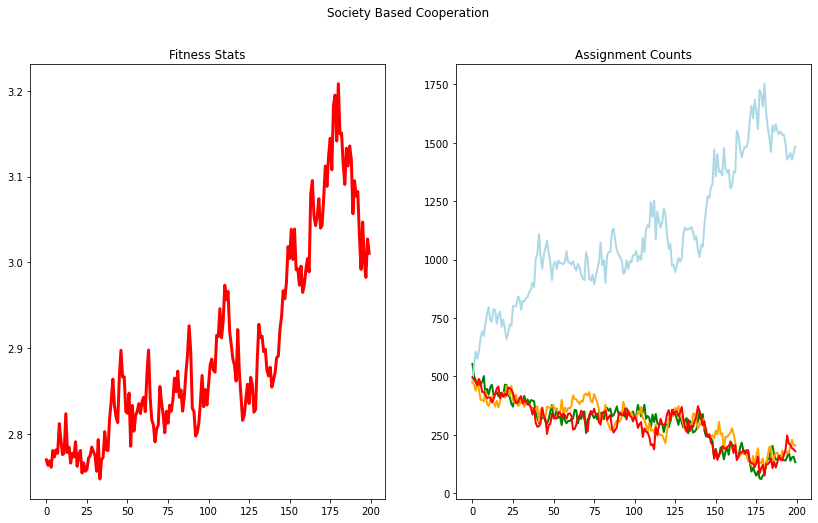

In [6]:
draw_graphs(lb, counts)